# Packages

In [1]:
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy 
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# Introduction

## Données de ce notebook

Les données proviennent du scrapping du site jeux.video.com, les données récupérées sont les avis sur le jeu Cyberpunk 2077 en version PC, on récupère via le scrapper_cyberpunk.py :
- le texte qui constitue l'avis
- la note associée (notation sur 20)
- la date, d'une précision horaire, à laquelle l'avis a été posté

## Objectif(s) de ce notebook

L'objectif principalement de ce notebook est de prédire si un avis est positif ou négatif on définit que :
- un avis est positif si sa note associée est >= 10
- un avis est négatif si sa note associée est < 10

Les autres objectifs comprennent :
- visualiser les données en particulier la date de post des avis
- tester de façon automatique différentes méthodes de preprocessing des données pour améliorer le modèle de machine learning créé


# Informations sur les données

In [2]:
data = pd.read_csv('scrapped_cyberpunk_2023-10-13.csv')

In [3]:
print(data.duplicated().sum())

data = data.drop_duplicates()

0


In [4]:
data.isna().sum()

review    0
rating    0
date      0
dtype: int64

In [5]:
data.date

0        Posté le 02 mars 2022 à 15:17
1       Posté le 24 févr. 2022 à 17:22
2        Posté le 01 mars 2022 à 21:46
3        Posté le 08 déc. 2021 à 14:34
4       Posté le 05 janv. 2021 à 15:10
                     ...              
1002    Posté le 23 janv. 2021 à 12:54
1003    Posté le 18 janv. 2021 à 17:34
1004    Posté le 18 janv. 2021 à 13:19
1005    Posté le 04 janv. 2021 à 12:09
1006     Posté le 30 déc. 2020 à 00:41
Name: date, Length: 1007, dtype: object

In [6]:
data.shape

(1007, 3)

In [7]:
data.head()

,review,rating,date
0,J'ai pu jouer à Cyberpunk 2077 un peu plus d'a...,18,Posté le 02 mars 2022 à 15:17
1,Pour moi cyberpunk est une claque!!! l'écritur...,18,Posté le 24 févr. 2022 à 17:22
2,Cyberpunk 2077 c'est racheté une conduite. Ave...,19,Posté le 01 mars 2022 à 21:46
3,On s'est tellement focalisé jusqu'au ridicule ...,18,Posté le 08 déc. 2021 à 14:34
4,"Pour moi c'est simple, je reconnais la qualité...",20,Posté le 05 janv. 2021 à 15:10


- On a a plus de 1 000 avis, sans données dupliquées ni de données manquantes.  
- La date n'est pas dans un bon format.


## Mettre la date au format datetime

In [8]:
data['date'] = data.date.str.strip('Posté le ').str.split(' à ').apply(lambda code: " ".join(code))

In [9]:
month_mapping = {'mars': '3',
                 'févr.': '2',
                 'déc.': '12',
                 'janv.': '1',
                 'sept.': '9',
                 'nov.': '11',
                 'oct.': '10',
                 'juil.': '7',
                 'juin': '6',
                 'mai': '5',
                 'août': '8',
                 'avr.': '4'
}

# Replace values in the dates Series using the mapping
data['date']  = data.date.replace(month_mapping, regex=True)

In [10]:
data.head()

,review,rating,date
0,J'ai pu jouer à Cyberpunk 2077 un peu plus d'a...,18,02 3 2022 15:17
1,Pour moi cyberpunk est une claque!!! l'écritur...,18,24 2 2022 17:22
2,Cyberpunk 2077 c'est racheté une conduite. Ave...,19,01 3 2022 21:46
3,On s'est tellement focalisé jusqu'au ridicule ...,18,08 12 2021 14:34
4,"Pour moi c'est simple, je reconnais la qualité...",20,05 1 2021 15:10


In [11]:
# index of dates with a missing information i.e year
pb_date_index = data[data.date.str.len()<15].date.index

# number of problematic dates
print(len(pb_date_index))

# in fact it's the current year that's missing
data.iloc[pb_date_index].date.head()

40


23     03 2 09:13
44     03 5 01:59
68     02 4 08:51
743    20 1 11:55
798    29 6 01:04
Name: date, dtype: object

In [12]:
# add the missing year for the pb dates
data.loc[pb_date_index,'date'] = data.loc[pb_date_index,'date'].str.rsplit(' ', n=1).apply(lambda x:x[0] +' '+str(date.today().year)+' '+x[1])

In [13]:
# change the dates to a datetime format
data['date']  = pd.to_datetime( data['date'],format = "%d %m %Y %H:%M")

In [14]:
data.date.head()

0   2022-03-02 15:17:00
1   2022-02-24 17:22:00
2   2022-03-01 21:46:00
3   2021-12-08 14:34:00
4   2021-01-05 15:10:00
Name: date, dtype: datetime64[ns]

# Ajout de nouvelles colonnes et visualisations

## Informations spécifiques sur la date

In [15]:
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
data['day'] = data.date.dt.day
data['hour'] = data.date.dt.hour

data['year_month'] = data.date.dt.to_period('M')

## Ajout de la colonne à prédire

In [16]:
data['is_bad_review'] = pd.cut(data.rating, bins=[0, 10, 20], labels=[1,0],include_lowest=True)

In [17]:
data.is_bad_review.value_counts()

is_bad_review
0    744
1    263
Name: count, dtype: int64

- Les mauvaises reviews sont fortement minoritaires.

## Tokenizer et ajout d'information sur les tokens

In [18]:
#!python -m spacy download fr_core_news_md

nlp = spacy.load("fr_core_news_md")

def custom_spacy_tokenizer(string):
    doc = nlp(string)
    l=[]
    for tok in doc:
        if(not(tok.is_stop) and not(tok.is_punct) and not(tok.is_digit)):
            l.append(tok.lemma_)
    return l

data["prepro_token"] = data.review.apply(custom_spacy_tokenizer)
data["nb_token"] = data.prepro_token.apply(len)

# Visualisations en lien avec la date

In [19]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

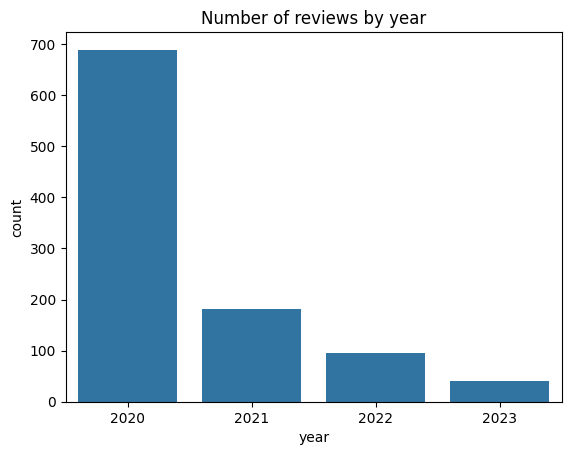

In [20]:
sns.countplot(data=data, x='year')
plt.title('Number of reviews by year')
plt.show()

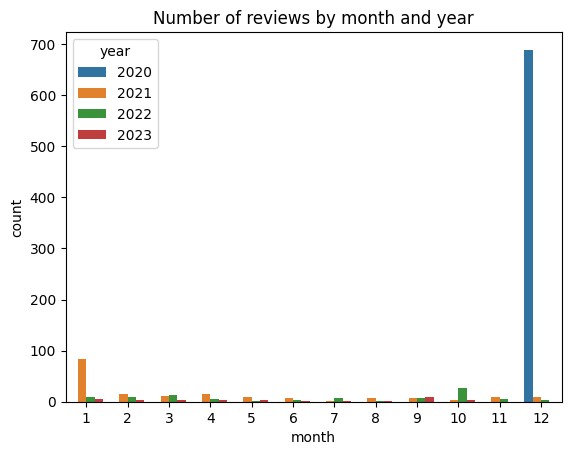

In [21]:
sns.countplot(data=data, x='month',hue='year',palette='tab10')
plt.title('Number of reviews by month and year')
plt.show()

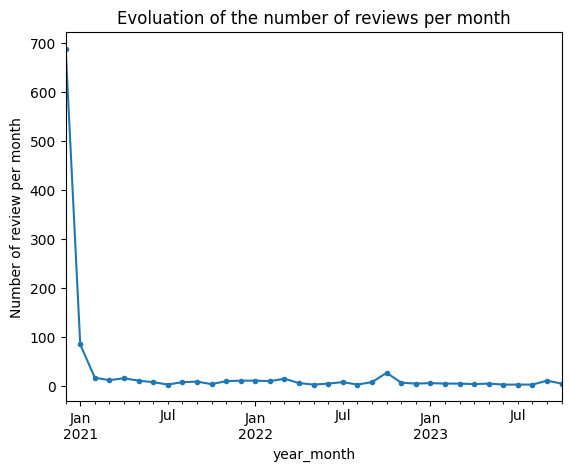

In [22]:
data.groupby('year_month').rating.size().plot(kind='line',style='.-')
plt.title('Evoluation of the number of reviews per month')
plt.ylabel('Number of review per month')
plt.show()

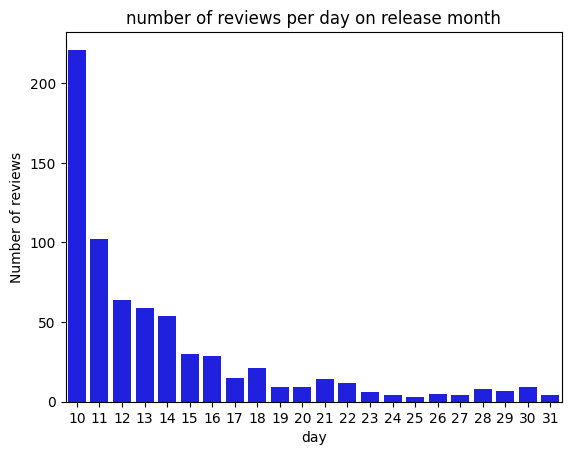

In [23]:
sns.countplot(data=data.query('year==2020'), x='day',color='b')
plt.title('number of reviews per day on release month')
plt.ylabel('Number of reviews')
plt.show()

- 70% des avis proviennent du mois de décembre de l'année 2020.
- Ce mois est le mois de lancement du jeu et près de 20% des avis totaux proviennent du jour de lancement le 10 Décembre 2020.
- Les autres avis de ce mois sont principalement postés dans la semaine qui suit le jour de lancement.

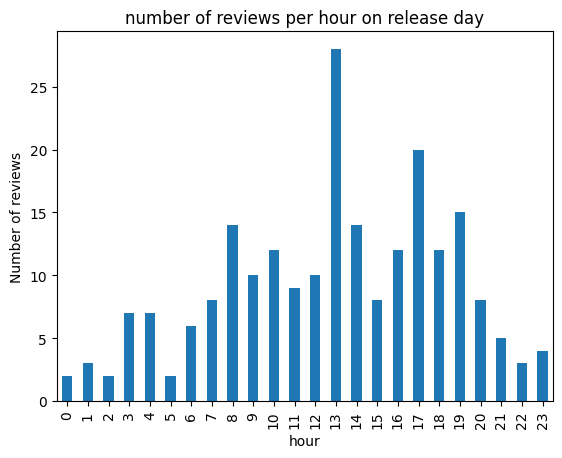

In [24]:
data.query('year == 2020 & month == 12 & day == 10').hour.value_counts().sort_index().plot(kind='bar')
plt.title('number of reviews per hour on release day')
plt.ylabel('Number of reviews')
plt.show()

- La plupart des avis du jour de lancement sont postés entre 8h et 19h.
- Il y a fort pic vers 13h.

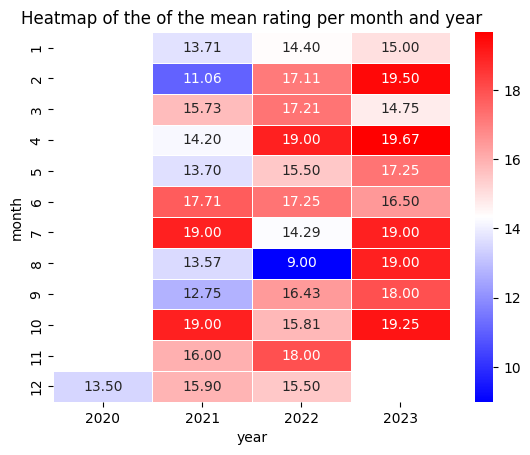

In [25]:
sns.heatmap(data.pivot_table(values='rating', index='month', columns='year'), annot = True, fmt=".2f", cmap="bwr", linewidths=0.5)
plt.title('Heatmap of the of the mean rating per month and year')
plt.show()

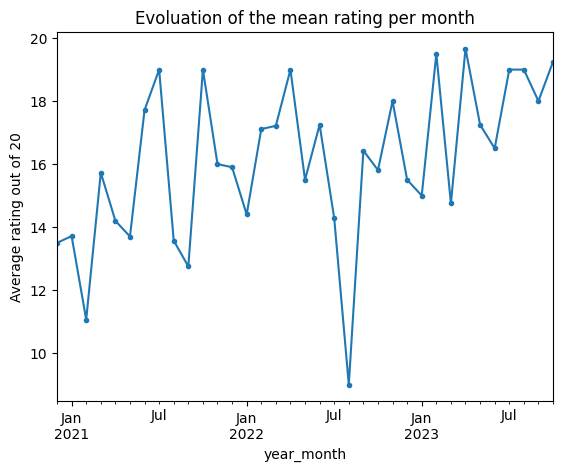

In [26]:
data.groupby('year_month').rating.mean().plot(kind='line',style='.-')
plt.title('Evoluation of the mean rating per month')
plt.ylabel('Average rating out of 20')
plt.show()

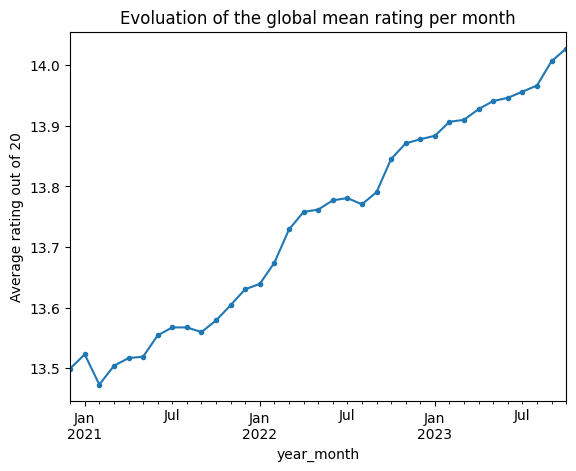

In [27]:
cum_sum = data.groupby('year_month')['rating'].sum().cumsum()
cum_size = data.groupby('year_month').rating.size().cumsum()
cum_mean_rating = cum_sum / cum_size

cum_mean_rating.plot(kind='line',style='.-')
plt.title('Evoluation of the global mean rating per month')
plt.ylabel('Average rating out of 20')
plt.show()

- La moyenne par mois a beaucoup fluctée depuis le lancement du jeu :
    - environ 13.5/20 au mois de lancement.
    - des pic jusqu'a 19/20 depuis ce qui est le cas pour ce début d'Octobre 2023.
- Malgrés cela la moyenne générale du jeu n'as pas bcp évolué elle a augmenté de 0.5 en presque 3 ans car il a trop peu de nouvelles critiques par mois comparé au nombre initial du mois de lancement.

## Visualisations concernant les tokens

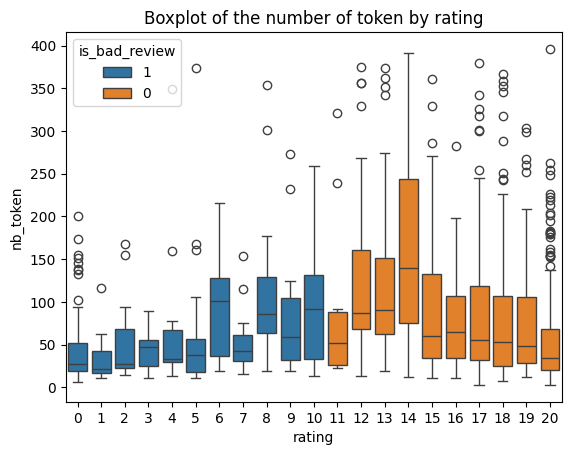

In [29]:
sns.boxplot(data=data,  x="rating", y="nb_token", hue="is_bad_review", dodge=False)
plt.title('Boxplot of the number of token by rating')
plt.show()

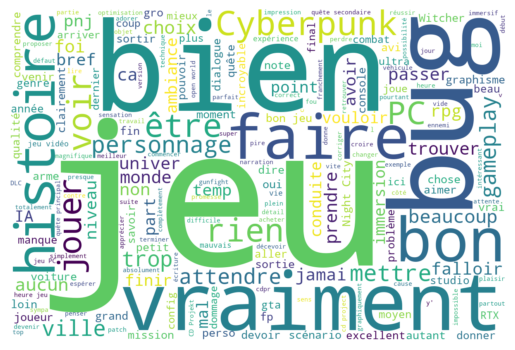

In [29]:
pos_text = ' '.join(data.prepro_token.explode().values)
pos_cloud = WordCloud(width=1200, height=800, background_color='white').generate(pos_text)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

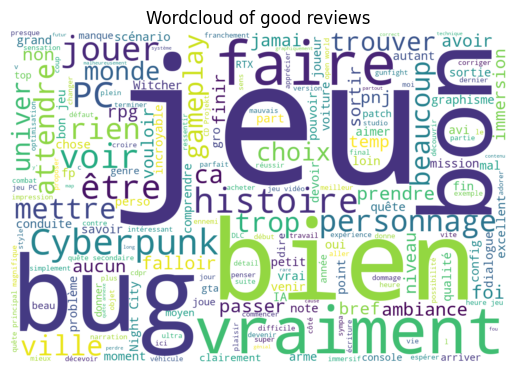

In [30]:
pos_text = ' '.join(data.query('is_bad_review==0').prepro_token.explode().values)
pos_cloud = WordCloud(width=1200, height=800, background_color='white').generate(pos_text)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud of good reviews')
plt.show()

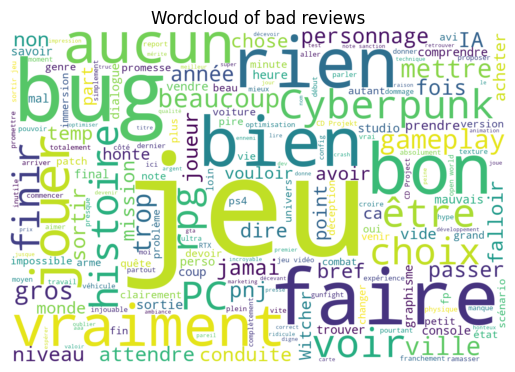

In [31]:
pos_text = ' '.join(data.query('is_bad_review==1').prepro_token.explode().values)
pos_cloud = WordCloud(width=1200, height=800, background_color='white').generate(pos_text)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.title('Wordcloud of bad reviews')
plt.axis("off")
plt.show()

# Partie Machine Learning

- Dans cette partie on va prédire si un avis est :
    - bon (codé par 0 74% des données) 
    - ou mauvais (codé par 1 26% des données)
- On est dans le cas d'un problème de classification binaire avec des données très déséquilibrées. 
-  Le focus sera fait à bien prédire la classe minoritaire "mauvais avis" par l'optimisation de son f1-score.


Pour automatiser le preprocessing des données et la classification de celles-ci on utilise la classe Pipeline de scikit-lean.  
Pour tester différentes méthodes de préprocessing et avoir un modèle robuste on utilise une GridSearchCV sur la pipeline d'entrainement.

On test :
- deux vectorizer CountVectorizer() ou TfidfVectorizer() avec comme modèle de token celui déclaré en amont et deux range de n-gram possibles :
    - token seul : ngram_range=(1, 1)
    - token seul et suite de deux tokens : ngram_range=(1, 2)
- deux sampler RandomOverSampler() ou RandomUnderSampler() avec une graine aléatoire pour la reproductibilié
- un classifier LogisticRegression()


## Création de la pipeline d'entrainement

In [32]:
X = data.review
y = data.is_bad_review

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5, stratify = y)

In [33]:
param_grid = {
    'vectorizer': [CountVectorizer(tokenizer = custom_spacy_tokenizer, token_pattern = None),
                   TfidfVectorizer(tokenizer = custom_spacy_tokenizer, token_pattern = None)],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],

    'sampler': [RandomOverSampler(random_state = 5),
                RandomUnderSampler(random_state = 5)],                    
}

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),  # type of vectorizer will be define by the gridsearch param_grid same for sampler
    ('sampler', RandomOverSampler()),
    ('classifier', LogisticRegression())
])

gs = GridSearchCV(pipeline, param_grid = param_grid, scoring='f1', verbose=2)
# f1 score computes score for the minority class (i.e 1 : reviews with bad rating)

In [34]:
gs.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END sampler=RandomOverSampler(random_state=5), vectorizer=CountVectorizer(token_pattern=None,
                tokenizer=<function custom_spacy_tokenizer at 0x0000020F78399940>), vectorizer__ngram_range=(1, 1); total time=  20.9s
[CV] END sampler=RandomOverSampler(random_state=5), vectorizer=CountVectorizer(token_pattern=None,
                tokenizer=<function custom_spacy_tokenizer at 0x0000020F78399940>), vectorizer__ngram_range=(1, 1); total time=  17.7s
[CV] END sampler=RandomOverSampler(random_state=5), vectorizer=CountVectorizer(token_pattern=None,
                tokenizer=<function custom_spacy_tokenizer at 0x0000020F78399940>), vectorizer__ngram_range=(1, 1); total time=  20.0s
[CV] END sampler=RandomOverSampler(random_state=5), vectorizer=CountVectorizer(token_pattern=None,
                tokenizer=<function custom_spacy_tokenizer at 0x0000020F78399940>), vectorizer__ngram_range=(1, 1); total time=  20.9s
[CV]

GridSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('sampler', RandomOverSampler()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'sampler': [RandomOverSampler(random_state=5),
                                     RandomUnderSampler(random_state=5)],
                         'vectorizer': [CountVectorizer(token_pattern=None,
                                                        tokenizer=<function custom_spacy_tokenizer at 0x0000020F78399940>),
                                        TfidfVectorizer(token_pattern=None,
                                                        tokenizer=<function custom_spacy_tokenizer at 0x0000020F78399940>)],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=2)

## Informations  concernant les résultats en validation

In [35]:
gs_results = pd.DataFrame(gs.cv_results_['params']).join(pd.Series(gs.cv_results_['mean_test_score'],name='mean_f1_score_val'))

In [36]:
gs_results

,sampler,vectorizer,vectorizer__ngram_range,mean_f1_score_val
0,RandomOverSampler(random_state=5),"CountVectorizer(token_pattern=None,\n ...","(1, 1)",0.663892
1,RandomOverSampler(random_state=5),"CountVectorizer(token_pattern=None,\n ...","(1, 2)",0.665612
2,RandomOverSampler(random_state=5),"TfidfVectorizer(token_pattern=None,\n ...","(1, 1)",0.704454
3,RandomOverSampler(random_state=5),"TfidfVectorizer(token_pattern=None,\n ...","(1, 2)",0.540277
4,RandomUnderSampler(random_state=5),"CountVectorizer(token_pattern=None,\n ...","(1, 1)",0.637864
5,RandomUnderSampler(random_state=5),"CountVectorizer(token_pattern=None,\n ...","(1, 2)",0.645064
6,RandomUnderSampler(random_state=5),"TfidfVectorizer(token_pattern=None,\n ...","(1, 1)",0.696513
7,RandomUnderSampler(random_state=5),"TfidfVectorizer(token_pattern=None,\n ...","(1, 2)",0.719780


In [37]:
gs.best_params_

{'sampler': RandomUnderSampler(random_state=5),
 'vectorizer': TfidfVectorizer(token_pattern=None,
                 tokenizer=<function custom_spacy_tokenizer at 0x0000020F78399940>),
 'vectorizer__ngram_range': (1, 2)}

- La pipeline avec la meilleure moyenne en validation du f1-score de 72% est celle comprenant comme preprocessing un :
    - RandomUnderSampler()
    - TfidfVectorizer(vectorizer__ngram_range': (1, 2))

- D'autres pipelines avec un n_gram_range de (1, 1) ont des performances en validation quasi-similaires ( environ 70% ).   
- Ce sont ainsi d'autres modèles que l'on pourrait sélectionner pour avoir un classifier avec deux fois moins de paramètres.

## Visualisation des tokens les plus importants pour le modèle retenu

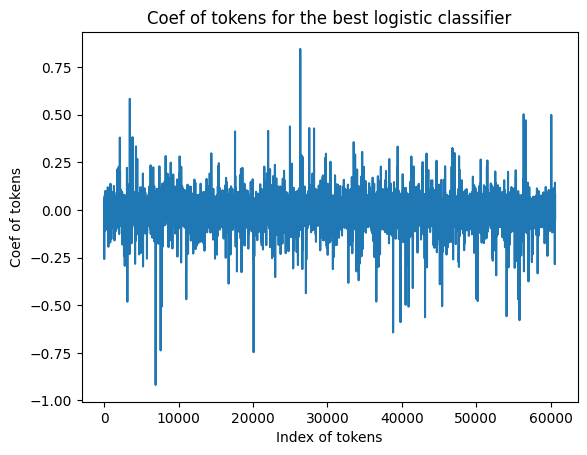

In [38]:
plt.plot(gs.best_estimator_.named_steps.classifier.coef_[0])
plt.title('Coef of tokens for the best logistic classifier')
plt.xlabel('Index of tokens')
plt.ylabel('Coef of tokens')
plt.show()

In [39]:
feat_coef = gs.best_estimator_.named_steps.classifier.coef_[0]
feat_name = gs.best_estimator_.named_steps.vectorizer.get_feature_names_out()

best_out = pd.DataFrame({'names':feat_name, 'coef':feat_coef})

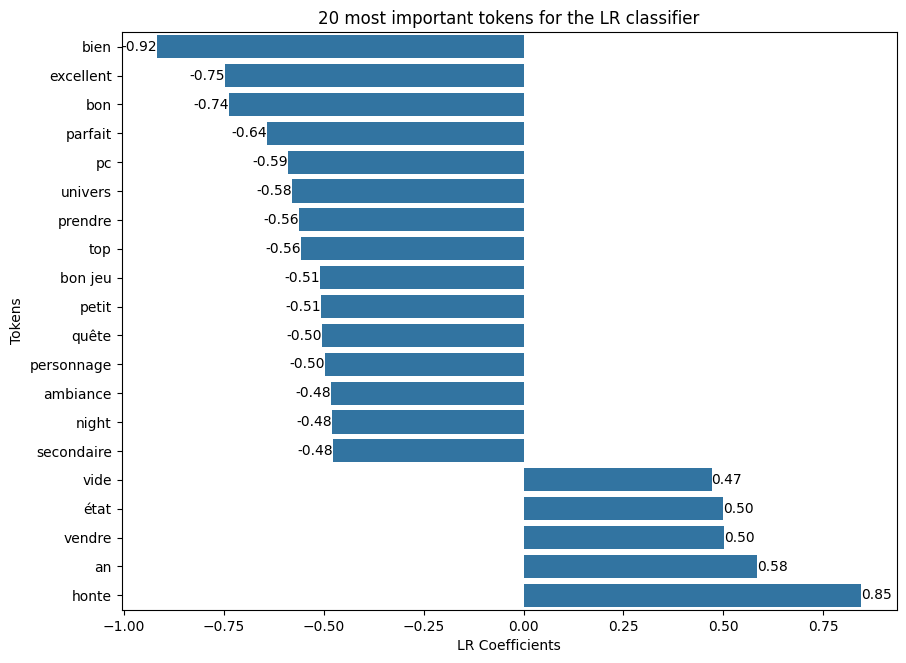

In [40]:
best_20_sorted = best_out.iloc[best_out.coef.abs().nlargest(20).index].sort_values(by='coef')

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 7.5))
sns.barplot(x='coef', y='names', data=best_20_sorted)

# Annotate the bars with their corresponding 'names'
for i, row in enumerate(best_20_sorted.iterrows()):
    if(row[1].iloc[1] <0):
        plt.text(row[1]['coef'], i, f'{row[1]["coef"]:.2f}', ha='right',va='center')
    if(row[1].iloc[1] >0):
        plt.text(row[1]['coef'], i, f'{row[1]["coef"]:.2f}', ha='left',va='center')

# Set labels and title
plt.xlabel('LR Coefficients')
plt.ylabel('Tokens')
plt.title('20 most important tokens for the LR classifier')

# Show the plot
plt.show()

- Dans les tokens les plus important on ne retrouve que des n_gram de taille 1 dont :
    - 3/4 qui influent vers la classe de bon avis, 'bien' est le token le plus décisif (coef de -0.92) pour un bon avis
    - contre 1/4 pour la classe de mauvais avis, 'honte' est le token le plus important (coef 0.85) pour un mauvais avis

# Evaluation du modèle sur le jeu de test

In [41]:
print(classification_report(y_test, gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       149
           1       0.74      0.79      0.76        53

    accuracy                           0.87       202
   macro avg       0.83      0.85      0.84       202
weighted avg       0.87      0.87      0.87       202



- En généralisation le modèle est plus performant qu'en validation avec un f1-score de 76% contre 72% précedemment.
- L'autre classe comprenant les bons avis qui sont majoritaires sont mieux prédit (f1-score de 91%) ce qui est attendu.

# Conclusion ML

- On a une pipeline qui permet de prédire avec un f1-score de 76% en généralisation si une review est mauvaise ou non en ce basant uniquement sur le texte de celle-ci, le f1-score en macro avg est meme de 84%.
- On a pu tester de façon automatique différents preprocessings.
- On pourrait également tester d'autres algorithmes de classification que la régression logistique et faire de l'optimisation des hyperparamètres de ces classifiers pour améliorer les performances.